In [ ]:
#default_exp augment.pil_filters

# ImageFilter Data Augmentation

> Apply `PIL.ImageFilter`s to your input images

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai2.vision.all import *
from PIL import ImageFilter

See the Pillow [docs](https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html) for more information on the `PIL.ImageFilter` module.

In this module, we create a patch that allows us to use a `PIL.ImageFilter` as a `RandTransform`, and demonstrate why it could be a useful form of data augmentation. More specifically, we'll see how using a `PIL.ImageFilter.Color3dLUT` can serve as a lossless transform of our image.

LUTs (Look Up Tables) are widely used in post processing pipelines for photos and videos. Their main purpose is to transform the look of an image and speed up the process of color correction. <br>
They come in various forms and extensions. This repo includes 3 luts in the `assets/luts` folder, and here's what the first few lines look like:
```python
0.00392157 0.00392157 0.00392157
0.00436408 0.00392157 0.00392157
0.0111086 0.00392157 0.00392157
0.0300908 0.00392157 0.00392157
```

In [ ]:
#export
def is_3dlut_row(row:list) -> bool:
    'Check if one line in the file has exactly 3 values'
    row_values = []
    for val in row:
        try: row_values.append(float(val))
        except: continue
    if len(row_values) == 3: return True
    else: return False

def read_lut(path_lut:Union[str,Path], num_channels:int=3):
    'Read LUT from raw file. Assumes each line in a file is part of the lut table'
    with open(path_lut) as f: lut_raw = f.read().splitlines()
    
    size      = round(len(lut_raw) ** (1/3))
    row2val   = lambda row: tuple([float(val) for val in row])
    lut_table = [row2val(row.split(' ')) for row in lut_raw if is_3dlut_row(row.split(' '))]
    
    return ImageFilter.Color3DLUT(size, lut_table, num_channels)

In [ ]:
#export
class ApplyPILFilter(RandTransform):
    "Apply a `PIL.ImageFilter` and return as a PILImage"
    order = 0 # Apply before `ToTensor`
    def __init__(self, filters, p=1.):
        super().__init__(p=p)
        self.filter = filters

    def select_filter(self, o):
        'If multiple `filters` are given, select and apply one'
        if isinstance(self.filter, (tuple,list,L)):
              rand_idx = np.random.randint(0, len(self.filter))
              return o.filter(self.filter[rand_idx])
        else: return o.filter(self.filter)
    
    #def _encodes(self, o:(PILImage,TensorImage,str,Path)): return TensorImage(self.select_filter(o)).permute(2,0,1)
    def _encodes(self, o): return PILImage(self.select_filter(o))
    
    def encodes(self, o:PILImage):               return self._encodes(o)
    def encodes(self, o:(TensorImage,str,Path)): return self._encodes(PILImage.create(o))

When creating an `ApplyPILFiler` object, you can enter input either a single or multiple `PIL.ImageFilter` as the `filters` argument. If you enter multiple, a random one will be selected at the time of applying the transform

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
show_doc(ApplyPILFilter.select_filter)

<h4 id="ApplyPILFilter.select_filter" class="doc_header"><code>ApplyPILFilter.select_filter</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>ApplyPILFilter.select_filter</code>(**`o`**)

```
If multiple `filters` are given, select and apply one
```

In [ ]:
luts   = [read_lut(f) for f in get_files('../assets/luts/', extensions='.cube')]
fnames = get_image_files('../assets')

In [ ]:
%%capture

f = fnames[2]
filt     = ApplyPILFilter(luts[2], p=1.) # pass in only one filter
img_raw  = PILImage.create(f)
img_filt = filt(f, split_idx=0)

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
show_tensor = lambda x,ax: ToTensor()(x).show(ctx=ax)

show_tensor(img_raw,ax[0]); show_tensor(img_filt,ax[1])

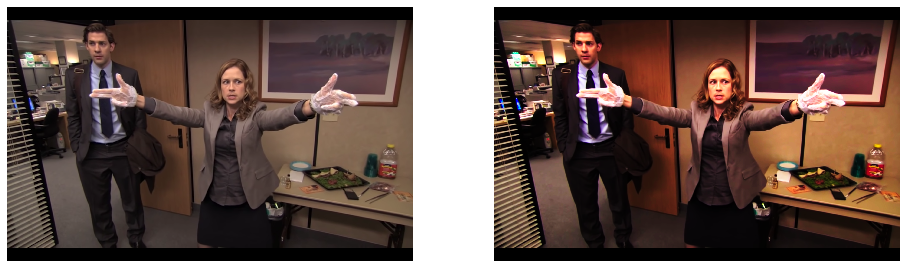

In [ ]:
fig

Note that we're now passing in a list `luts` to `ApplyPILFilter`, so every time it's called, a random item from `luts` is applied to the image.

For the purpose of showing the augs happen, I create multiple copies of the same image offline. <br>

In [ ]:
dblock = DataBlock(
    blocks     = (ImageBlock, CategoryBlock),
    get_items  = get_image_files,
    get_x      = Pipeline([PILImage.create, ApplyPILFilter(luts, p=1.)]),
    get_y      = parent_label,
    splitter   = RandomSplitter(seed=42, valid_pct=0.),
    item_tfms  = [Resize(size=224, method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = dblock.dataloaders('../assets/imgs', bs=15)

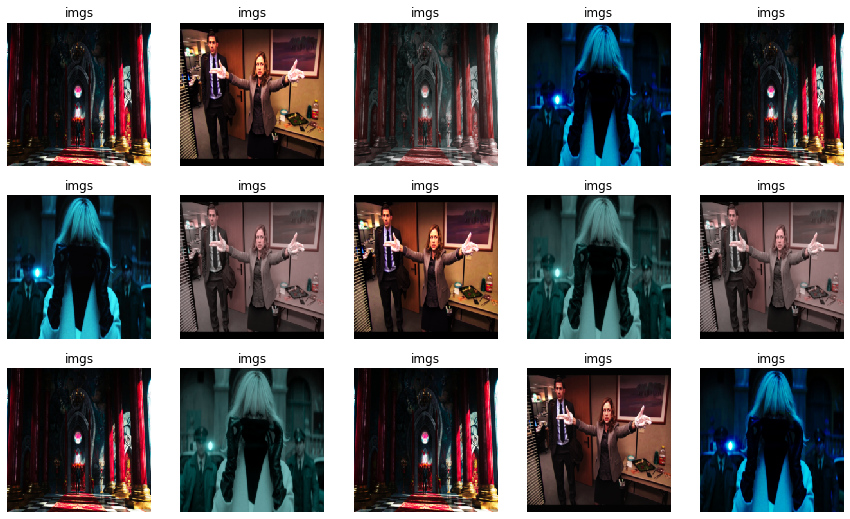

In [ ]:
dls.show_batch(max_n=15)